In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

c:\Users\Reyna\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('bankruptcy_data.csv')
df.columns = df.columns.str.strip()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
df.shape

(6819, 96)

In [4]:
df["Bankrupt?"].sum()

220

In [5]:
df["Bankrupt?"].mean()

0.03226279513125092

In [84]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier()
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

init_f1 = f1_score(y_test, y_pred)
init_roc_auc = roc_auc_score(y_test, y_proba)
init_pf_auc = average_precision_score(y_test, y_proba)
init_conf_matrix = confusion_matrix(y_test, y_pred)

print(f'F1 Score: {init_f1}')
print(f'ROC AUC: {init_roc_auc}')
print(f'Precision Recall: {init_pf_auc}')
print(f'Confusion Matrix: {init_conf_matrix}')

F1 Score: 0.4507042253521127
ROC AUC: 0.9569042699724517
Precision Recall: 0.5313581345161422
Confusion Matrix: [[1309   11]
 [  28   16]]


In [85]:
correlation_matrix = df.corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df_reduced = df.drop(columns=correlated_features)
correlated_features

{'After-tax net Interest Rate',
 'CFO to Assets',
 'Cash Flow to Liability',
 'Cash Flow to Sales',
 'Continuous interest rate (after tax)',
 'Current Assets/Total Assets',
 'Current Liabilities/Equity',
 'Current Liability to Assets',
 'Current Liability to Equity',
 'Current Liability to Liability',
 'Equity to Long-term Liability',
 'Gross Profit to Sales',
 'Inventory and accounts receivable/Net value',
 'Liability to Equity',
 "Net Income to Stockholder's Equity",
 'Net Income to Total Assets',
 'Net Value Per Share (A)',
 'Net Value Per Share (C)',
 'Net Worth Turnover Rate (times)',
 'Net profit before tax/Paid-in capital',
 'Net worth/Assets',
 'Operating Funds to Liability',
 'Operating Profit Per Share (Yuan ¥)',
 'Operating profit/Paid-in capital',
 'Per Share Net profit before tax (Yuan ¥)',
 'Persistent EPS in the Last Four Seasons',
 'Pre-tax net Interest Rate',
 'ROA(A) before interest and % after tax',
 'ROA(B) before interest and depreciation after tax',
 'Realized Sal

In [86]:
positive_samples = df_reduced["Bankrupt?"].sum()
negative_samples = len(df_reduced) - positive_samples
scale_pos_weight = negative_samples / positive_samples

In [87]:
X = df_reduced.drop('Bankrupt?', axis=1)
y = df_reduced['Bankrupt?']

In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_oos, y_test, y_oos = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [103]:
X_oos.head(10).to_csv('inference_test.csv')

In [89]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

c:\Users\Reyna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

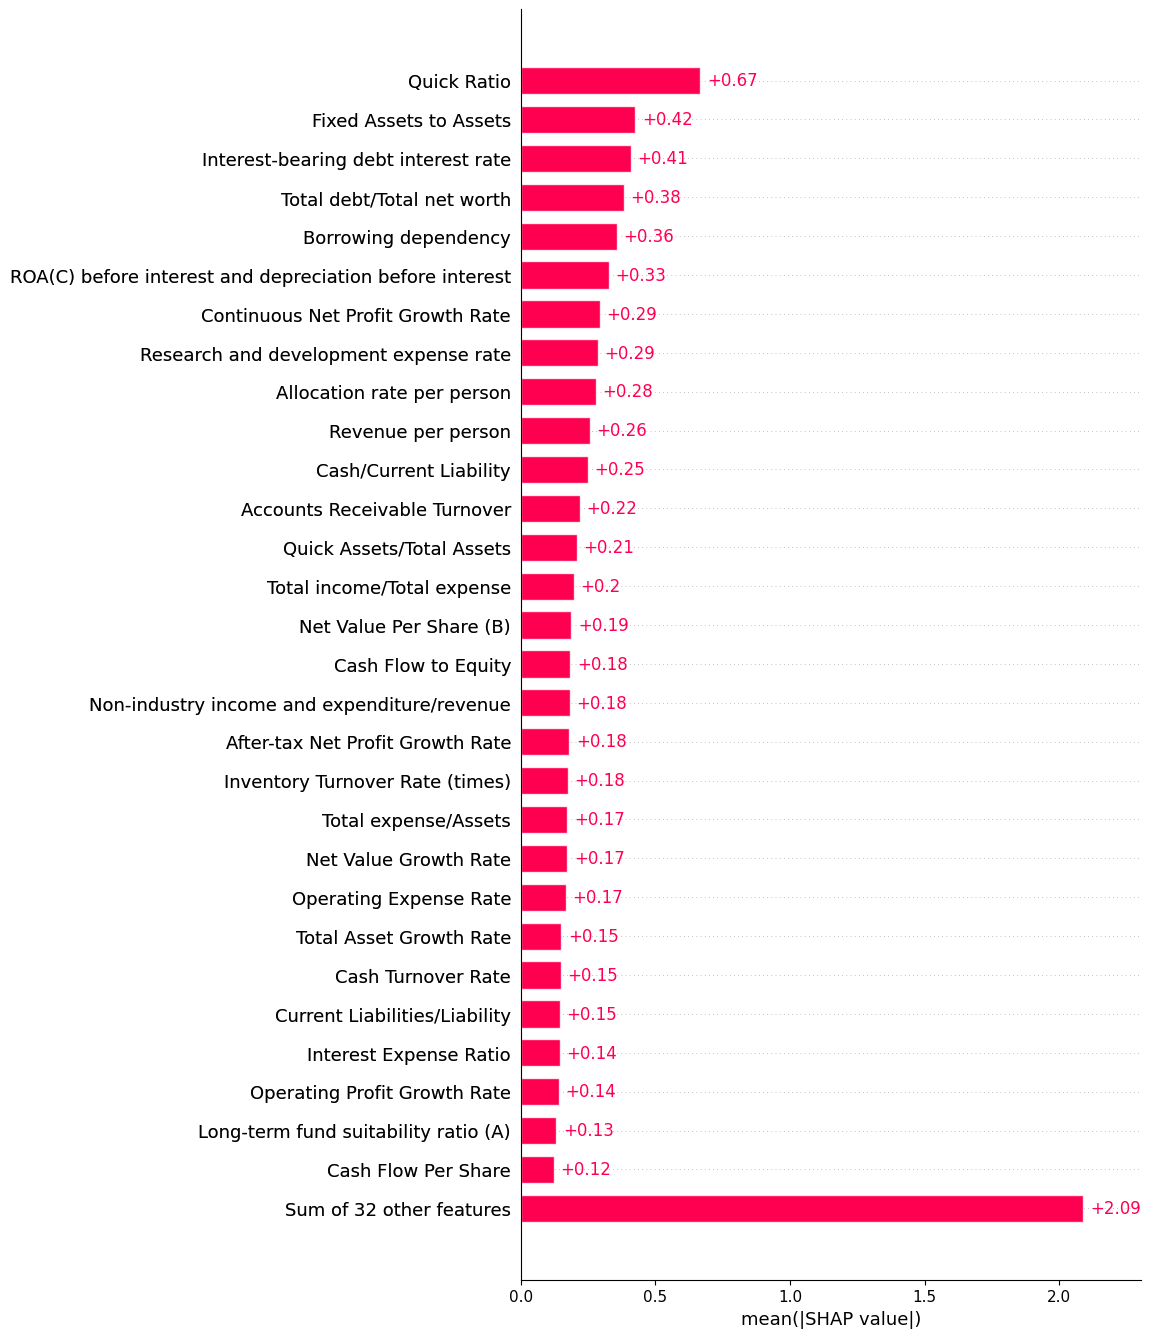

In [90]:
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_train)
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)

shap.plots.bar(shap_values, max_display=30)

In [91]:
selected_features = feature_importance_df['Feature'].values[:30]
X_train_subset = X_train[selected_features]

model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0],
    'scale_pos_weight': [scale_pos_weight] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=cv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train)

print("Best ROC AUC:", random_search.best_score_)
print("Best params: ", random_search.best_params_)

c:\Users\Reyna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best ROC AUC: 0.9504207870854791
Best params:  {'subsample': 0.6, 'scale_pos_weight': 29.995454545454546, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [92]:
model = random_search.best_estimator_

y_proba = model.predict_proba(X_test[selected_features])[:, 1]
y_pred = model.predict(X_test[selected_features])

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pf_auc = average_precision_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

oos_y_proba = model.predict_proba(X_oos[selected_features])[:, 1]
oos_y_pred = model.predict(X_oos[selected_features])
oos_f1 = f1_score(y_oos, oos_y_pred)
oos_roc_auc = roc_auc_score(y_oos, oos_y_proba)
oos_pf_auc = average_precision_score(y_oos, oos_y_proba)
oos_conf_matrix = confusion_matrix(y_oos, oos_y_pred)

print()
print(f'F1 Score: {init_f1}')
print(f'ROC AUC: {init_roc_auc}')
print(f'Precision Recall: {init_pf_auc}')
print(f'Confusion Matrix: {init_conf_matrix}')

print()
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision Recall: {pf_auc}')
print(f'Confusion Matrix: {conf_matrix}')

print()
print(f'F1 Score: {oos_f1}')
print(f'ROC AUC: {oos_roc_auc}')
print(f'Precision Recall: {oos_pf_auc}')
print(f'Confusion Matrix: {oos_conf_matrix}')


F1 Score: 0.4507042253521127
ROC AUC: 0.9569042699724517
Precision Recall: 0.5313581345161422
Confusion Matrix: [[1309   11]
 [  28   16]]

F1 Score: 0.5641025641025641
ROC AUC: 0.9603305785123967
Precision Recall: 0.5521295763354215
Confusion Matrix: [[654   6]
 [ 11  11]]

F1 Score: 0.47619047619047616
ROC AUC: 0.9526859504132232
Precision Recall: 0.5329516509062302
Confusion Matrix: [[650  10]
 [ 12  10]]


In [93]:
model.save_model("model.json")

In [98]:
print(str(list(model.feature_names_in_)).replace(',', ',\n'))

['Quick Ratio',
 'Fixed Assets to Assets',
 'Interest-bearing debt interest rate',
 'Total debt/Total net worth',
 'Borrowing dependency',
 'ROA(C) before interest and depreciation before interest',
 'Continuous Net Profit Growth Rate',
 'Research and development expense rate',
 'Allocation rate per person',
 'Revenue per person',
 'Cash/Current Liability',
 'Accounts Receivable Turnover',
 'Quick Assets/Total Assets',
 'Total income/Total expense',
 'Net Value Per Share (B)',
 'Cash Flow to Equity',
 'Non-industry income and expenditure/revenue',
 'After-tax Net Profit Growth Rate',
 'Inventory Turnover Rate (times)',
 'Total expense/Assets',
 'Net Value Growth Rate',
 'Operating Expense Rate',
 'Total Asset Growth Rate',
 'Cash Turnover Rate',
 'Current Liabilities/Liability',
 'Interest Expense Ratio',
 'Operating Profit Growth Rate',
 'Long-term fund suitability ratio (A)',
 'Cash Flow Per Share',
 'Average Collection Days']


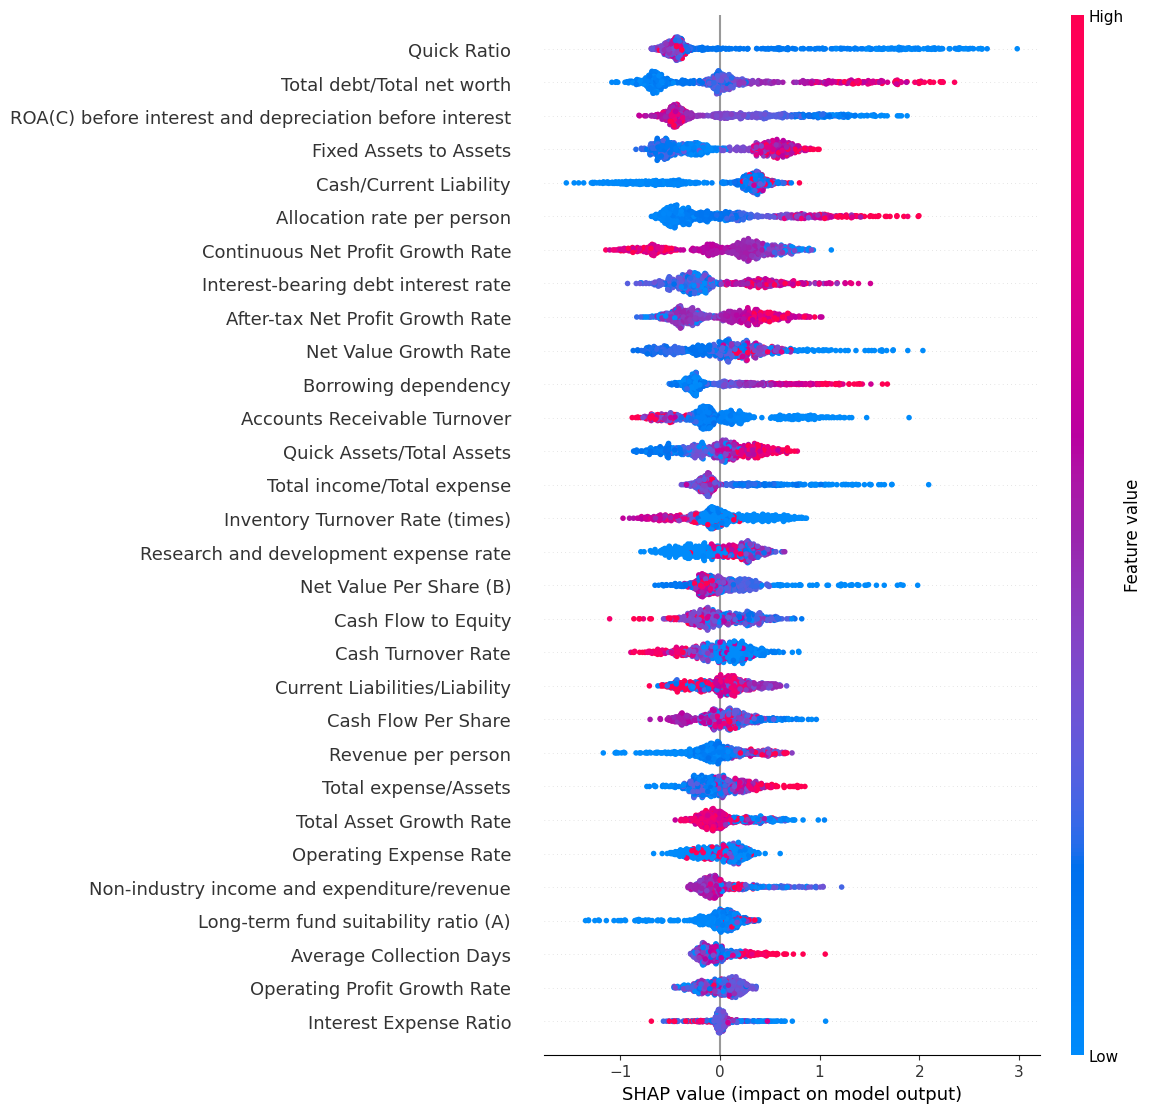

In [97]:
explainer = shap.TreeExplainer(model, X_oos[selected_features])
shap_values = explainer(X_oos[selected_features])

shap.plots.beeswarm(shap_values, max_display=len(selected_features))